# LIBRARIES

In [2]:
%pip install tensorflow.keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\HanDong\Documents\Study\Semester 5\DPL302m\project\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import librosa
import librosa.display
import os
from librosa.effects import pitch_shift as lr_pitch_shift
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import IPython.display as ipd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Data Preprocessing

## RAVDESS Dataset

In [20]:
ravdess = "RAVDESS"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [23]:
file_emotion = []
file_path = []

# Loop though each actor folder
for folder in ravdess_directory_list:
    actor = os.listdir(ravdess + '/' + folder)

    # extract audio files for each actor folder
    for file in actor:
        part = file.split('.')[0].split('-')
        
        # The third part in each file name represents the emotion of that audio file
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + '/' + folder + '/' + file)

ravdess_df = pd.DataFrame({'Emotion': file_emotion, 
                           'Path': file_path})
ravdess_df

,Emotion,Path
0,1,RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,1,RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,1,RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,1,RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,2,RAVDESS/Actor_01/03-01-02-01-01-01-01.wav
...,...,...
1435,8,RAVDESS/Actor_24/03-01-08-01-02-02-24.wav
1436,8,RAVDESS/Actor_24/03-01-08-02-01-01-24.wav
1437,8,RAVDESS/Actor_24/03-01-08-02-01-02-24.wav
1438,8,RAVDESS/Actor_24/03-01-08-02-02-01-24.wav


In [ ]:
ravdess_df["Emotion"] = ravdess_df["Emotion"].replace({1: 'neutral',
                                                       2: 'neutral',
                                                       3: 'happy',
                                                       4: 'sad',
                                                       5: 'angry',
                                                       6: 'fearful',
                                                       7: 'disgust',
                                                       8: 'surprised'})
print(ravdess_df["Emotion"].value_counts())

Emotion
neutral      288
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
Name: count, dtype: int64


## CREMA-D Dataset


In [25]:
crema = 'CREMA-D'
crema_directory_list = os.listdir(crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    part = file.split('.')[0].split('_')
    
    # The third part in each file name represents the emotion of that audio file
    file_emotion.append(part[2])
    file_path.append(crema + '/' + file)

crema_df = pd.DataFrame({'Emotion': file_emotion,
                         'Path': file_path})
crema_df

,Emotion,Path
0,ANG,CREMA-D/1001_DFA_ANG_XX.wav
1,DIS,CREMA-D/1001_DFA_DIS_XX.wav
2,FEA,CREMA-D/1001_DFA_FEA_XX.wav
3,HAP,CREMA-D/1001_DFA_HAP_XX.wav
4,NEU,CREMA-D/1001_DFA_NEU_XX.wav
...,...,...
7437,DIS,CREMA-D/1091_WSI_DIS_XX.wav
7438,FEA,CREMA-D/1091_WSI_FEA_XX.wav
7439,HAP,CREMA-D/1091_WSI_HAP_XX.wav
7440,NEU,CREMA-D/1091_WSI_NEU_XX.wav


In [ ]:
crema_df["Emotion"] = crema_df["Emotion"].replace({'ANG': 'angry',
                                                   'DIS': 'disgust',
                                                   'FEA': 'fearful',
                                                   'HAP': 'happy',
                                                   'SAD': 'sad',
                                                   'NEU': 'neutral'})
print(crema_df["Emotion"].value_counts())

Emotion
angry      1271
disgust    1271
fearful    1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


## SAVEE dataset

In [27]:
savee = 'SAVEE'
savee_directory_list = os.listdir(savee)
print(savee_directory_list)

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav', 'DC_a06.wav', 'DC_a07.wav', 'DC_a08.wav', 'DC_a09.wav', 'DC_a10.wav', 'DC_a11.wav', 'DC_a12.wav', 'DC_a13.wav', 'DC_a14.wav', 'DC_a15.wav', 'DC_d01.wav', 'DC_d02.wav', 'DC_d03.wav', 'DC_d04.wav', 'DC_d05.wav', 'DC_d06.wav', 'DC_d07.wav', 'DC_d08.wav', 'DC_d09.wav', 'DC_d10.wav', 'DC_d11.wav', 'DC_d12.wav', 'DC_d13.wav', 'DC_d14.wav', 'DC_d15.wav', 'DC_f01.wav', 'DC_f02.wav', 'DC_f03.wav', 'DC_f04.wav', 'DC_f05.wav', 'DC_f06.wav', 'DC_f07.wav', 'DC_f08.wav', 'DC_f09.wav', 'DC_f10.wav', 'DC_f11.wav', 'DC_f12.wav', 'DC_f13.wav', 'DC_f14.wav', 'DC_f15.wav', 'DC_h01.wav', 'DC_h02.wav', 'DC_h03.wav', 'DC_h04.wav', 'DC_h05.wav', 'DC_h06.wav', 'DC_h07.wav', 'DC_h08.wav', 'DC_h09.wav', 'DC_h10.wav', 'DC_h11.wav', 'DC_h12.wav', 'DC_h13.wav', 'DC_h14.wav', 'DC_h15.wav', 'DC_n01.wav', 'DC_n02.wav', 'DC_n03.wav', 'DC_n04.wav', 'DC_n05.wav', 'DC_n06.wav', 'DC_n07.wav', 'DC_n08.wav', 'DC_n09.wav', 'DC_n10.wav', 'DC_n11.wav', 'DC_n

In [30]:
file_emotion = []
file_path = []

for file in savee_directory_list:
    part = file.split('.')[0].split('_')
    file_emotion.append(part[1][:-2])
    file_path.append(savee + '/' + file)

savee_df = pd.DataFrame({'Emotion': file_emotion,
                         'Path': file_path})
savee_df

,Emotion,Path
0,a,SAVEE/DC_a01.wav
1,a,SAVEE/DC_a02.wav
2,a,SAVEE/DC_a03.wav
3,a,SAVEE/DC_a04.wav
4,a,SAVEE/DC_a05.wav
...,...,...
475,su,SAVEE/KL_su11.wav
476,su,SAVEE/KL_su12.wav
477,su,SAVEE/KL_su13.wav
478,su,SAVEE/KL_su14.wav


In [32]:
savee_df["Emotion"] = savee_df["Emotion"].replace({'n': 'neutral',
                          'd': 'disgust',
                          'a': 'angry',
                          'f': 'fearful',
                          'h': 'happy',
                          'sa': 'sad',
                          'su': 'surprised'})
print(savee_df["Emotion"].value_counts())

Emotion
neutral      120
disgust       60
angry         60
fearful       60
happy         60
sad           60
surprised     60
Name: count, dtype: int64


## TESS Dataset

In [36]:
tess = 'TESS'
tess_directory_list = os.listdir(tess)
print(tess_directory_list)

['OAF_angry', 'OAF_disgust', 'OAF_Fear', 'OAF_happy', 'OAF_neutral', 'OAF_Pleasant_surprise', 'OAF_Sad', 'YAF_angry', 'YAF_disgust', 'YAF_fear', 'YAF_happy', 'YAF_neutral', 'YAF_pleasant_surprised', 'YAF_sad']


In [37]:
file_emotion = []
file_path = []

# Loop though each emotion folder
for folder in tess_directory_list:
    files = os.listdir(tess + '/' + folder)

    # Extract each audio file
    for file in files:
        part = file.split('.')[0].split('_')
        file_emotion.append(part[2])
        file_path.append(tess + '/' + folder + '/' + file)

tess_df = pd.DataFrame({'Emotion': file_emotion,
                        'Path': file_path})
tess_df

,Emotion,Path
0,angry,TESS/OAF_angry/OAF_back_angry.wav
1,angry,TESS/OAF_angry/OAF_bar_angry.wav
2,angry,TESS/OAF_angry/OAF_base_angry.wav
3,angry,TESS/OAF_angry/OAF_bath_angry.wav
4,angry,TESS/OAF_angry/OAF_bean_angry.wav
...,...,...
2795,sad,TESS/YAF_sad/YAF_witch_sad.wav
2796,sad,TESS/YAF_sad/YAF_yearn_sad.wav
2797,sad,TESS/YAF_sad/YAF_yes_sad.wav
2798,sad,TESS/YAF_sad/YAF_young_sad.wav


In [38]:
tess_df["Emotion"] = tess_df["Emotion"].replace({'fear': 'fearful',
                         'ps': 'surprised'})
print(tess_df["Emotion"].value_counts())

Emotion
angry        400
disgust      400
fearful      400
happy        400
neutral      400
surprised    400
sad          400
Name: count, dtype: int64


## Combine Datasets


In [39]:
combined_df = pd.concat([ravdess_df, savee_df, tess_df, crema_df])
print(combined_df.Emotion.value_counts())

Emotion
happy        1923
sad          1923
angry        1923
disgust      1923
fearful      1923
neutral      1895
surprised     652
Name: count, dtype: int64


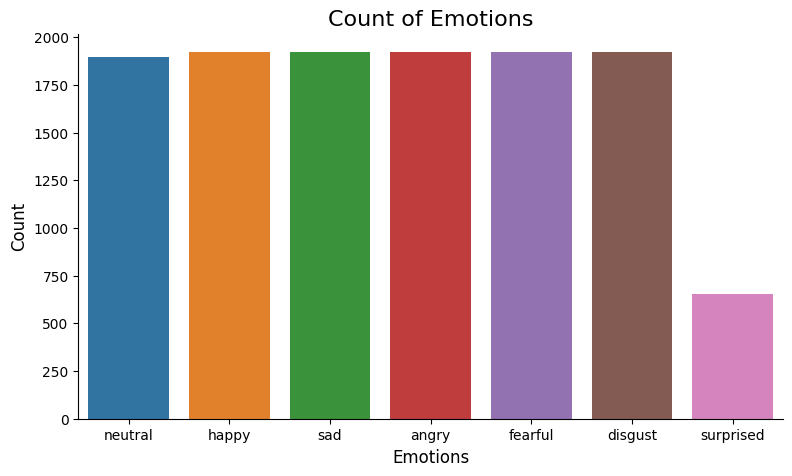

In [47]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(121)
plt.title('Count of Emotions', size=16)
sns.countplot(x=combined_df["Emotion"], hue=combined_df["Emotion"], legend=False)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

## Resample Data

In [49]:
# Giả sử đây là DataFrame bạn đang dùng
df_all = pd.concat([ravdess_df, crema_df, savee_df, tess_df], ignore_index=True)

# Kiểm tra số lượng mỗi lớp
print("Original dataset:")
print(df_all['Emotion'].value_counts())

# Lấy class phổ biến nhất để làm mốc oversample
max_count = df_all['Emotion'].value_counts().max()

# Tách các lớp theo emotion
df_balanced = pd.DataFrame()

for emotion in df_all['Emotion'].unique():
    df_emotion = df_all[df_all['Emotion'] == emotion]
    if len(df_emotion) < max_count:
        df_emotion_upsampled = resample(df_emotion,
                                        replace=True,
                                        n_samples=max_count,
                                        random_state=42)
    else:
        df_emotion_upsampled = df_emotion
    df_balanced = pd.concat([df_balanced, df_emotion_upsampled])

# Shuffle lại
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Kiểm tra lại
print("\nBalanced dataset:")
print(df_balanced['Emotion'].value_counts())


Original dataset:
Emotion
happy        1923
sad          1923
angry        1923
disgust      1923
fearful      1923
neutral      1895
surprised     652
Name: count, dtype: int64

Balanced dataset:
Emotion
neutral      1923
sad          1923
fearful      1923
disgust      1923
surprised    1923
angry        1923
happy        1923
Name: count, dtype: int64


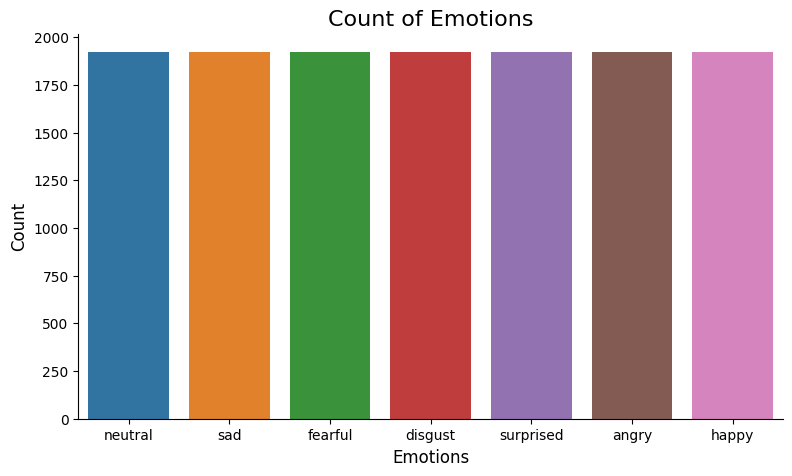

In [51]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(121)
plt.title('Count of Emotions', size=16)
sns.countplot(x=df_balanced["Emotion"], hue=df_balanced["Emotion"], legend=False)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

## Data Augmentation


In [ ]:
def noise(data, noise_factor=0.005):
    return data + noise_factor * np.random.randn(len(data))

def shift(data, shift_max=0.2, sr=22050):
    shift = int(random.uniform(-shift_max, shift_max) * sr)
    return np.roll(data, shift)

def stretch(data, rate=1.1):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def augment_audio(y, sr):
    return [
        noise(y),
        shift(y),
        stretch(y, rate=random.uniform(0.8, 1.2)),
        pitch(y, sr=sr, n_steps=random.randint(-2, 2))
    ]

### Data Augmentation example

In [ ]:
# Load a sample audio file
y, sr = librosa.load(file_path[0])

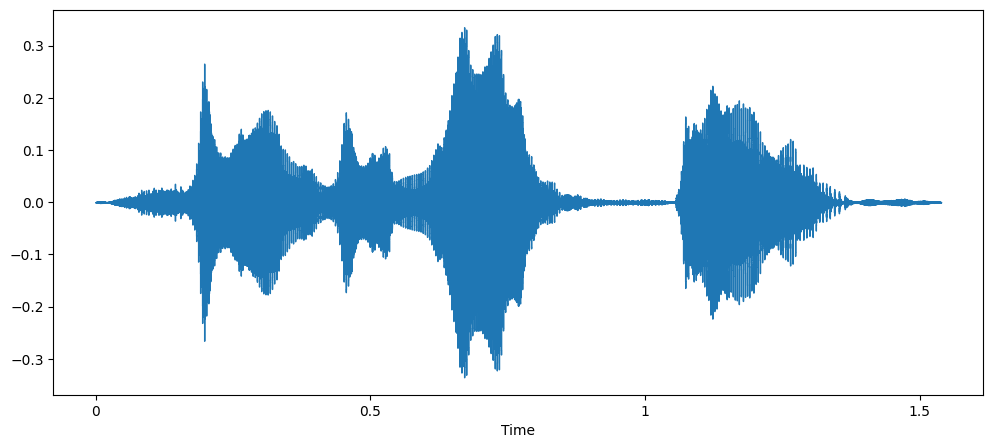

In [ ]:
# NORMAL AUDIO
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=y, sr=sr)
ipd.Audio(y,rate=sr)

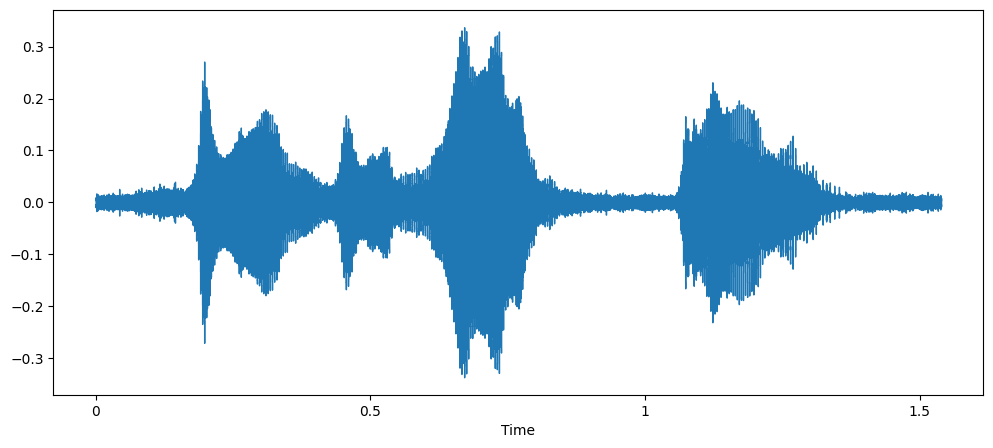

In [22]:
# AUDIO WITH NOISE
x = noise(y)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

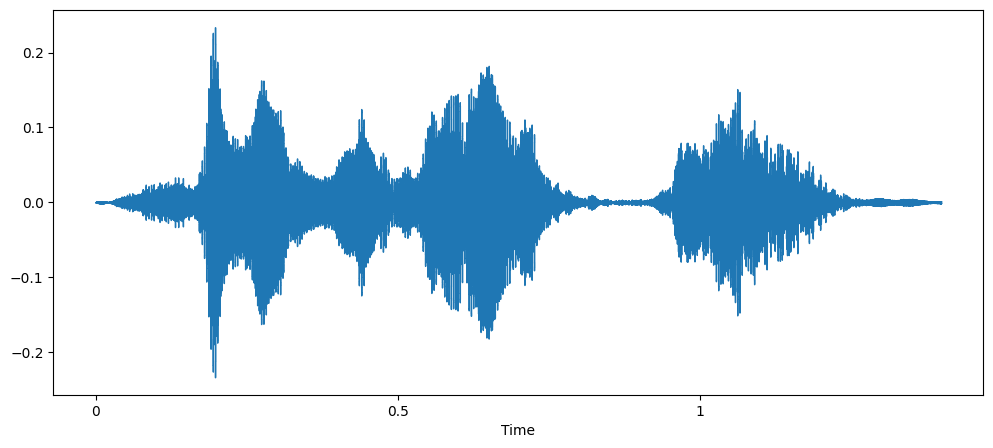

In [23]:
# STRETCHED AUDIO
x = stretch(y)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

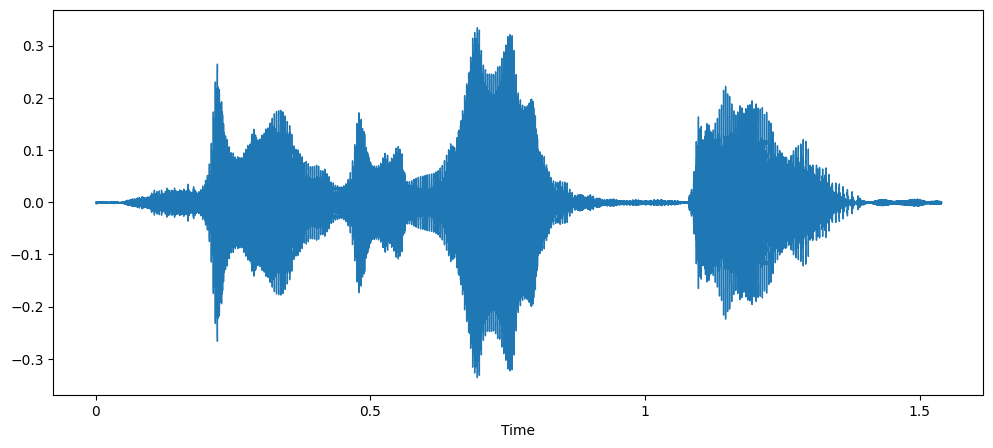

In [24]:
# SHIFTED AUDIO
x = shift(y)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

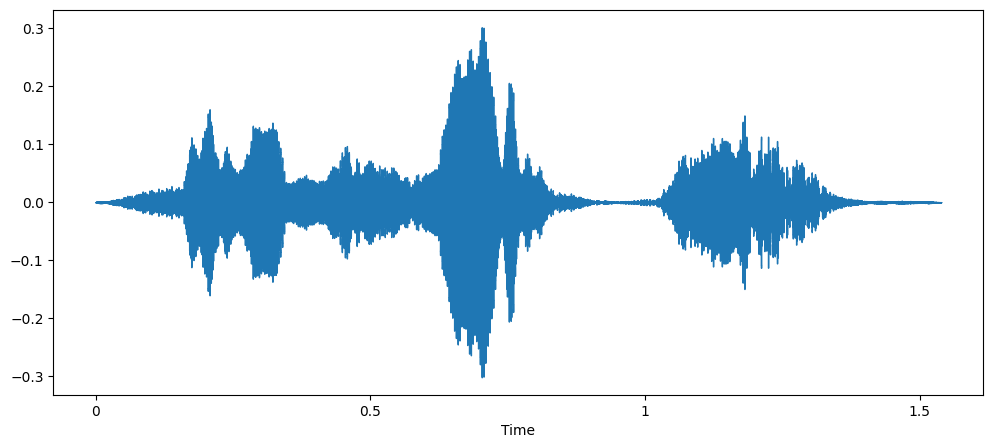

In [25]:
# AUDIO WITH PITCH
x = pitch(y, sr=sr, n_steps=2)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature Extraction


In [52]:
def audio_to_melspectrogram_3d_from_wave(y, sr=16000, n_mels=64, frame_length=2.0, fixed_n_frames=10):
    """
    Convert audio waveform to a 3D array of mel-spectrograms with fixed shape.

    Args:
        y: NumPy array of audio waveform (shape: (n_samples,))
        sr: Sampling rate (default: 22050 Hz)
        n_mels: Number of mel bands (default: 64)
        frame_length: Length of each frame in seconds (default: 2.0)
        fixed_n_frames: Desired number of frames in output (default: 10)

    Returns:
        NumPy array of shape (fixed_n_frames, n_mels, time_steps, channels=1)
    """
    # Calculate samples per frame
    samples_per_frame = int(frame_length * sr)

    # Split audio into frames
    duration = len(y) / sr
    total_frames = int(np.ceil(duration / frame_length))  # Round up to include partial frames
    frames = []

    for i in range(total_frames):
        start = i * samples_per_frame
        end = min(start + samples_per_frame, len(y))
        y_frame = y[start:end]

        # Pad frame if too short
        if len(y_frame) < samples_per_frame:
            y_frame = np.pad(y_frame, (0, samples_per_frame - len(y_frame)), mode='constant')

        # Compute mel-spectrogram for the frame
        mel = librosa.feature.melspectrogram(y=y_frame, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        frames.append(mel_db)

    # Convert to NumPy array and add channel dimension
    frames = np.array(frames)[..., np.newaxis]  # Shape: (n_frames, n_mels, time_steps, 1)

    # Pad or truncate to fixed_n_frames
    current_n_frames = frames.shape[0]
    if current_n_frames < fixed_n_frames:
        # Pad with zero-filled spectrograms
        pad_shape = (fixed_n_frames - current_n_frames, n_mels, frames.shape[2], 1)
        padded_frames = np.zeros(pad_shape)
        frames = np.concatenate([frames, padded_frames], axis=0)
    elif current_n_frames > fixed_n_frames:
        # Truncate excess frames
        frames = frames[:fixed_n_frames]

    return frames  # Shape: (fixed_n_frames, n_mels, time_steps, 1)

# Data Preparation

In [53]:
X = df_balanced['Path']
y = df_balanced['Emotion']

df_balanced

,Emotion,Path
0,neutral,CREMA-D/1085_IWW_NEU_XX.wav
1,sad,CREMA-D/1081_IWW_SAD_XX.wav
2,fearful,RAVDESS/Actor_20/03-01-06-01-01-01-20.wav
3,neutral,TESS/OAF_neutral/OAF_room_neutral.wav
4,sad,CREMA-D/1085_ITH_SAD_XX.wav
...,...,...
13456,sad,CREMA-D/1083_IWW_SAD_XX.wav
13457,surprised,TESS/OAF_Pleasant_surprise/OAF_peg_ps.wav
13458,sad,TESS/OAF_Sad/OAF_cheek_sad.wav
13459,neutral,CREMA-D/1006_DFA_NEU_XX.wav


In [54]:
# Define emotion mappings
emotion_mapping = {'neutral': 0, 'happy': 1, 'sad': 2, 'angry': 3,
                    'fearful': 4, 'disgust': 5, 'surprised': 6}
reverse_mapping = {index: emotion for emotion, index in emotion_mapping.items()}

def process_audio(X, y, emotion_mapping, sr=16000):
    return (
        [audio_to_melspectrogram_3d_from_wave(*librosa.load(per_X, sr=sr)) for per_X in X],
        [emotion_mapping[per_y] for per_y in y]
    )

processed_X, processed_y = process_audio(X, y, emotion_mapping)
new_X, new_y = np.array(processed_X), np.array(processed_y)

In [ ]:
# def audio_to_augmented_spectrograms(path, sr=22050):
#     y, sr = librosa.load(path, sr=sr)
#     tensors = [audio_to_melspectrogram_3d_from_wave(y, sr)]
#     for aug in augment_audio(y, sr):
#         tensors.append(audio_to_melspectrogram_3d_from_wave(aug, sr))
#     return tensors


# def process_audio(X, y, emotion_mappings, sr=16000):
#     new_X, new_y = [], []

#     for idx, row in df_balanced.iterrows():
#         tensors = audio_to_augmented_spectrograms(row['Path'])  # gốc + 4 augmentations
#         label = emotion_labels[row['Emotion']]
#         for t in tensors:
#             new_X.append(t)
#             new_y.append(label)

In [55]:
# 60% train, 20% valid, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    new_X, new_y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# (number of samples, fixed_n_frames, n_mels, time_steps, channels=1)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (8076, 10, 64, 63, 1)
Validation data shape: (2692, 10, 64, 63, 1)
Test data shape: (2693, 10, 64, 63, 1)


# Model

In [ ]:
def build_3d_cnn_model(input_shape, num_classes):
    """
    Build a 3D CNN model for speech emotion recognition
    """
    model = models.Sequential([
        layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling3D((1, 2, 2)),

        layers.Conv3D(128, (3, 3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((1, 2, 2)),
        layers.Dropout(0.3),

        layers.Conv3D(256, (3, 3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((1, 2, 2)),
        layers.Dropout(0.3),

        layers.Conv3D(128, (3, 3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((1, 2, 2)),
        layers.Dropout(0.3),

        layers.GlobalAveragePooling3D(),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax'),
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build model
num_classes = len(emotion_mapping)
input_shape = X_train.shape[1:]  # (10, 64, 63, 1)
model = build_3d_cnn_model(input_shape, num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 10, 64, 63, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 64, 63, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 32, 31, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 32, 31, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 32, 31, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 32, 31, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 10, 16, 15, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 16, 15, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 10, 16, 15, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 16, 15, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 10, 8, 7, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 8, 7, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,587,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,659,175 (17.77 MB)

 Trainable params: 4,658,695 (17.77 MB)

 Non-trainable params: 480 (1.88 KB)

In [58]:
# Callbacks for training
callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

# Training

In [59]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

# Save final model
model.save("speech_emotion_model.h5")

Epoch 1/50
 44/127 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 0.2002 - loss: 2.4230

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [ ]:
# Predict on test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
print("Classification Report:")
class_names = [reverse_mapping[i] for i in sorted(reverse_mapping.keys())]
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=per_class_accuracy)
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()